# Labs 5-6: Regression and Regularisation

## Linear regression using TensorFlow
This example is also included in the other notebook Week 5's lab. The setting is that there exists a function $y=f(x) = ax+b$ and we aim to learn the values of $a,b$. In fact, this very basic setting can be solved optimally (see also the lectures), but the underlying mechanism applies to more complex settings that do not admit an analytical solution.

In the following, please read also the comments in each code snippet.

In [ ]:
# Let's import necessary libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
rng = np.random 

In [ ]:
# We define the learning parameters
learning_rate = 0.01 # how quickly do we adjust based on the observed error
training_steps = 1000 # how long do we train for
display_step = 50 # how ofter should we print on the screen

In [ ]:
# Training Data. These were arbitrarily selected. Feel free to play with different values.
X = np.array([2.167, 3.1, 3.3, 4.168, 4.4, 5.313, 5.5, 5.654, 6.182, 6.71, 6.93, 7.042, 7.59, 7.997, 9.27, 9.779, 10.791])
Y = np.array([1.221,  1.3, 1.573, 1.65, 1.694, 1.7,2.09, 2.42, 2.53, 2.596, 2.76, 2.827, 2.904, 2.94, 3.19, 3.366, 3.465])

# Let's plot the data. We will plot them again later.
plt.scatter(X,Y)

We wish to identify what are $a$ (the *slope*) and $b$ (the *intercept*). We begin by providing random initial values.

In [ ]:
# Weight and Bias, initialized randomly.
slope = tf.Variable(rng.randn(), name="slope")
intercept = tf.Variable(rng.randn(), name="intercept")

It is now time to define the function $f(x)$. Recall that in Python, we can define a function by using **def function_name(arguments)**

In [ ]:
# Linear regression (ax + b). This is where the define the corresponding function.
# In particular, we are given in input a variable x and we output ax+b

def linear_regression(x):
    return slope* x + intercept

We also need to define how to evaluate the accuracy of our *prediction*. That is, we need an *error function*.

Do you get what **tf.square()** in the next snippet does? Similarly, what does **reduce_mean** accomplish?

In [ ]:
# Mean square error. This is where we define the error function.
# For each data point, we compute (predicted_value - true_value)^2 and sum over all data points
# Recall from the lectures that just taking into account the actual error is not a good idea
# as positive and negative errors cancel out

def mean_square(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))

We need to define which *optimizer* we plan to use. TensorFlow supports a [large class of optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers).

In [ ]:
# Stochastic Gradient Descent Optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

If the next snippet seems too complex (this may well be the case!), please check again Lab 5 and in particular the sections on *Automatic Differentiation* and *Gradient Descent*.

In [ ]:
# Optimization process. 
def run_optimization():
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = linear_regression(X) # this is our prediction
        loss = mean_square(pred, Y) # this captures our error function

    # Compute gradients. Since we have two variables, we get two gradients.
    gradients = g.gradient(loss, [slope, intercept])
    
    # Update a and b following gradients. What does zip do? Can you figure it out?
    optimizer.apply_gradients(zip(gradients, [slope, intercept]))

In [ ]:
# Run training for the given number of steps.
for step in range(1, training_steps + 1):
    # Run the optimization to update a and b values.
    run_optimization()
    
    if step % display_step == 0:
        pred = linear_regression(X)
        loss = mean_square(pred, Y)
        print("step: %i, loss: %f, a: %f, b: %f" % (step, loss, slope.numpy(), intercept.numpy()))

In [ ]:
# Let's visualize the solution. This provides a trivial way to forecast the output for any given input.
# Indeed, for any value x, we compute slope*x+intercept.

xfit = np.linspace(min(X), max(X))
yfit = slope*xfit+intercept
plt.scatter(X,Y)
plt.plot(xfit,yfit)

# Let's see another approach
TensorFlow is probably an overkill if we are only interested in tasks as regression. Let's see an approach based on [sklearn](https://scikit-learn.org/stable/). Sklearn allows for many traditional machine learning algorithms to be implemented in a rather easy way. Compared to Tensorflow, sklearn in more high-level but Tensorflow is more appropriate for Neural-Network based learning.

In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

In [ ]:
# let's generate some random data. In this case, we generate 100 random samples with 1 feature (what we are solving for)
# and a standard deviation of 10 for the noise added
XX, yy = make_regression(n_samples=10, n_features=1, noise=10.0)

# let's scale the data. XX takes values in [0,10] while yy in [20000, 100000]
XX = np.interp(XX, (XX.min(), XX.max()), (0, 20))
yy = np.interp(yy, (yy.min(), yy.max()), (20000, 100000))

In [ ]:
# now we fit the data and compute the slope and the intercept
reg = LinearRegression().fit(XX, yy)
reg.score(XX, yy)
print("slope: ",reg.coef_)
print("intercept: ", reg.intercept_)

In [ ]:
# Let's also calculate the theoretical values for the slope and the intercept as described in slide 19 (Unit 3)
avg_x = np.mean(XX)
avg_y = np.mean(yy)
math_slope = np.dot(yy-avg_y,XX-avg_x)/sum(np.multiply(XX-avg_x,XX-avg_x))
print(math_slope)
math_intercept = avg_y - math_slope*avg_x
print(math_intercept)

In [ ]:
# Let's plot the data and see how we did
xfit = np.linspace(min(XX), max(XX))
yfit = reg.coef_*xfit+reg.intercept_
math_yfit = math_slope*xfit+math_intercept
plt.scatter(XX,yy)
plt.plot(xfit,yfit)

# Conclusion so far
It is easy to see that the sklearn approach is simpler for this task. On the other hand, this means that the user has little control of how things are taken care of in sklearn.

You can consider using the XX, yy data from the sklearn example and then follow the Tensorflow learning approach. What do you observe? Why is the solution computed in the Tensorflow approach different than that of the sklearn approach?

# Multiple linear regression (see also slide 21)
So far we discussed the case of a single feature (a single variable $x$). A more general case is when there exist several independent features. That is, the input is a tuple ($x_1$, $x_2$, ..., $x_k$) and the output is still a single number $y$. In this case, we are searching for $k+1$ parameters $a_1$, $a_2$, ..., $a_k$ and $b$ such that $y = \sum_{i}{a_ix_i}+b$.

Note, however, that a natural question in this setting is "How to detect if the features are independent?"

The following simple example demonstrates linear regression with two independent features.

In [ ]:
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt

# Let's use some data. The values are rather arbitrary.
Stock_Market = {'Year': [2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019],
                'Month': [12, 11,10,9,8,7,6,5,4,3,2,1,12,11,10,9,8,7,6,5,4,3,2,1],
                'Interest_Rate': [2.75,2.75,2.5,2.5,2.5,2.5,2.25,2.25,2.25,2.25,2.25,2,2,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.5,1.5],
                'Unemployment_Rate': [5.2,5.2,5.3,5.3,5.4,5.6,5.5,5.5,5.5,5.6,5.7,5.9,6,5.9,5.8,6.2,6.2,6.1,6.1,6.1,5.9,6.2,6.2,6.1],
                'Stock_Index_Price': [1475,1400,1350,1300,1250,1250,1225,1200,1150,1175,1125,1075,1050,975,950,950,975,950,875,850,875,825,700,725]        
                }

# We create a dataframe
df = pd.DataFrame(Stock_Market,columns=['Year','Month','Interest_Rate','Unemployment_Rate','Stock_Index_Price']) 

In [ ]:
# Let's visualize the data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))

#plot 1st scatter 
ax1.scatter(df['Interest_Rate'].astype(float),df['Stock_Index_Price'].astype(float), color = 'r')
ax1.legend(['Interest Rate Vs. Stock Index Price']) 
ax1.set_xlabel('Interest Rate')
ax1.set_ylabel('Price')
ax1.plot()

#plot 2nd scatter 
ax2.scatter(df['Unemployment_Rate'].astype(float),df['Stock_Index_Price'].astype(float), color = 'g')
ax2.legend(['Unemployment_Rate Vs. Stock Index Price']) 
ax2.set_xlabel('Unemployment Rate')
ax2.set_ylabel('Price')
ax2.plot()

In [ ]:
# We have 2 input variables for multiple regression. If we just want to use one variable for simple linear regression,
# then use X = df['Interest_Rate'] for example. Alternatively, we may add additional variables within the brackets

X = df[['Interest_Rate','Unemployment_Rate']].astype(float)  

# output variable (what we are trying to predict)
Y = df['Stock_Index_Price'].astype(float) 

# Obtain the parameters using sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)
print('Intercept: ', regr.intercept_)
print('Coefficients: ', regr.coef_)

In [ ]:
# Let's put some arbitrary values for interest and unemployment rate and see what is the prediction
New_Interest_Rate = 2.4
New_Unemployment_Rate = 5
print('Predicted Stock Index Price: ', regr.predict([[New_Interest_Rate ,New_Unemployment_Rate]]))

# Polynomial regression, underfitting, overfitting
The multiple linear regression case refers to *independent* attributes. If this is not the case and the attributes are dependent (e.g., consider the case where $y = a_1 x^4+a_2 x^3+a_3 x^2 +a_4x+b$) we are still able to get the parameters. A small example follows.

This example demonstrates also the problems of underfitting and overfitting. The plot shows the function that we want to approximate, which is a part of the cosine function. In addition, the samples from the real function and the approximations of different models are displayed. The models have polynomial features of different degrees. 

We can see that a linear function (polynomial with degree 1) is not sufficient to fit the training samples. This is called *underfitting*. A polynomial of degree 4 approximates the true function almost perfectly. However, for higher degrees the model will *overfit* the training data, i.e. it learns the noise of the training data.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [ ]:
# we define the true function
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

# let's initialise our data. We will create 20 data points that come from the true function, but with the addition of some noise

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15] #the three choices for the polynomial degrees

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.2
X = X[:, np.newaxis]
y = y[:, np.newaxis]

X_test = np.linspace(0, 1, 100)


In [ ]:
# Here we take care of plotting the three cases, for different degrees (1, 4, 15)
polynomial_features = PolynomialFeatures(1) # First case, degree = 1
X_poly = polynomial_features.fit_transform(X)

linear_regression = LinearRegression()
linear_regression.fit(X_poly, y)
y_pred = linear_regression.predict(X_poly)

plt.figure(figsize=(14, 5))
plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
plt.plot(X,y_pred, color='r', label="Model")
plt.plot(X_test,true_fun(X_test), color='g', label="True function")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Underfitting with degree = 1")
plt.legend(loc="best")
plt.show()

In [ ]:
polynomial_features = PolynomialFeatures(4) # Second case, degree = 4
X_poly = polynomial_features.fit_transform(X)

linear_regression = LinearRegression()
linear_regression.fit(X_poly, y)
y_pred = linear_regression.predict(X_poly)

plt.figure(figsize=(14, 5))
plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
plt.plot(X,y_pred, color='r', label="Model")
plt.plot(X_test,true_fun(X_test), color='g', label="True function")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Appropriate capacity with degree = 4")
plt.legend(loc="best")
plt.show()

In [ ]:
polynomial_features = PolynomialFeatures(15) # Last case, degree = 15
X_poly = polynomial_features.fit_transform(X)

linear_regression = LinearRegression()
linear_regression.fit(X_poly, y)
y_pred = linear_regression.predict(X_poly)

plt.figure(figsize=(14, 5))
plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
plt.plot(X,y_pred, color='r', label="Model")
plt.plot(X_test,true_fun(X_test), color='g', label="True function")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Overfitting with degree = 15")
plt.legend(loc="best")
plt.show()

Is it clear what is the problem with the model using a polynomial of degree 15?

# Regularisation

Let's now bring regularisation into play. Parameter alpha below is the regularisation hyperparameter $\lambda$ in our model. What happens when alpha is small? What happens when it is large, let's say 100? Are there cases where a value is small for L2 but too large for L1?

We now also print the weights, so that it is easier to compare to the case where $\lambda=0$, which corresponds to no regularisation.

In [ ]:
from sklearn import linear_model

# L2 regression
l2_regression = linear_model.Ridge(alpha=0.01)
l2_regression.fit(X_poly, y)
y2_pred = l2_regression.predict(X_poly)

# L1 regression
l1_regression = linear_model.Lasso(alpha=0.01)
l1_regression.fit(X_poly, y)
y1_pred = l1_regression.predict(X_poly)


# Let's print the weights
print("L2 weights: ", l2_regression.coef_)
print("L1 weights: ", l1_regression.coef_)


plt.figure(figsize=(14, 5))
plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
plt.plot(X,y2_pred, color='r', label="Model with L2")
plt.plot(X,y1_pred, color='k', label="Model with L1")
plt.plot(X_test,true_fun(X_test), color='g', label="True function")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regularisation on a polynomial of degree 15")
plt.legend(loc="best")
plt.show()

**Task 1:** What does the following code do?

In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
IBM = pd.read_csv('IBM.csv')
IBMreturns = (IBM['Adj Close'] - IBM['Adj Close'].shift(1))/IBM['Adj Close'].shift(1)
IBM['IBMReturns'] = IBMreturns

In [3]:
model = LinearRegression()

C:\Users\sofia\AppData\Local\Temp\ipykernel_12460\1967874209.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pd[T] = y_pred
C:\Users\sofia\AppData\Local\Temp\ipykernel_12460\1967874209.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pd[T] = y_pred
C:\Users\sofia\AppData\Local\Temp\ipykernel_12460\1967874209.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pd[T] = y_pred
C:\Users\sofia\AppData\Local\Temp\ipykernel_12460\1967874209.py:15: DeprecationWar

-0.01811920518948057
-0.03156745979655448
-0.022098862960155674
-0.04278283491279638
-0.026070425795228985
-0.02059113556384925
-0.024934834254857808
-0.02184127155836241
-0.026137859818739964
-0.0409532457719705
-0.03781695203866925
-0.03765561392252316
-0.05137193093495844
-0.04022899248874426
-0.032987204456306325
-0.02673534148262669
-0.03186099800233391
-0.03935511747872032
-0.04524381812036789
-0.052648282360339305
-0.036400681531548754
-0.035487147945817726
-0.031912202088857304
-0.030472111882405596
-0.04644122575230604
-0.047440980991242894
-0.0465188388763812
-0.057112272760800664
-0.060991569687033106
-0.06748354557520392
-0.061104742254374116
-0.0504572270508916
-0.047371066425520296
-0.04864105079165494
-0.045311463062455086
-0.04839292445897102
-0.07201177807076554
-0.001009048142298144
0.010052286846250374
-0.0013886017458853758
-0.007537003317301359
-0.028457218671931107
-0.020159974412647705
-0.025194913110237225
-0.051200604123685226
-0.057478313721659034
-0.061386754

C:\Users\sofia\AppData\Local\Temp\ipykernel_12460\1967874209.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pd[T] = y_pred
C:\Users\sofia\AppData\Local\Temp\ipykernel_12460\1967874209.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pd[T] = y_pred
C:\Users\sofia\AppData\Local\Temp\ipykernel_12460\1967874209.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pd[T] = y_pred
C:\Users\sofia\AppData\Local\Temp\ipykernel_12460\1967874209.py:15: DeprecationWar

0.10676819435727998
0.114676927806655
0.12576785062220422
0.13263315312071866
0.14471336790964995
0.15372040175964852
0.16301003560925822
0.15797655923929377
0.17835659792142428
0.18433223344968155
0.19553926670108251
0.18990984062693636
0.16304029690687374
0.16357725303157783
0.16917928417211253
0.17789981372264924
0.16847978991109872
0.15405749777616493
0.1624306231286242
0.1546181410640883
0.1605691469050711
0.16617355165092537
0.1775521895750182
0.1514539069505401
0.1479961197738178
0.130766831551374
0.11658246802370946
0.12019691036864406
0.10900141923231592
0.11984863014167091
0.11680700114036638
0.09605847958695032
0.10176290675064169
0.10397589753412292
0.09559732701489305
0.08639232395618815
0.10957740474882054
0.08685198844536748
0.11968877682476146
0.12160104285837889
0.09368637743607702
0.12158460743835689
0.13058983965341905
0.13016512702799957
0.12821258791715184
0.09231902340863199
0.07794996401545333
0.06562079317928363
0.07730620922576756
0.07380857145211618
0.02654711

C:\Users\sofia\AppData\Local\Temp\ipykernel_12460\1967874209.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pd[T] = y_pred
C:\Users\sofia\AppData\Local\Temp\ipykernel_12460\1967874209.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pd[T] = y_pred
C:\Users\sofia\AppData\Local\Temp\ipykernel_12460\1967874209.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pd[T] = y_pred
C:\Users\sofia\AppData\Local\Temp\ipykernel_12460\1967874209.py:15: DeprecationWar

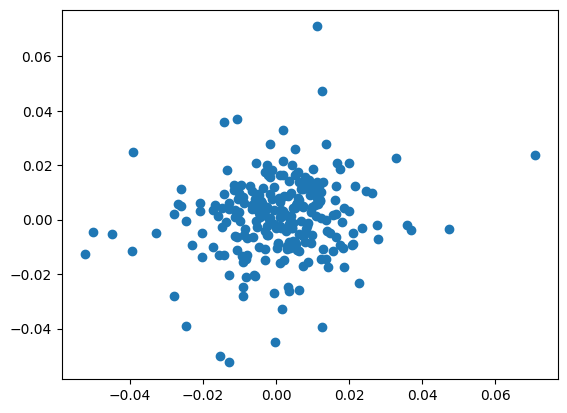

In [4]:
nsamples = 250
W = 1
td = np.zeros(nsamples-W-2)
pd = np.zeros(nsamples-W-2)
cumulative_return = 0
cr = np.zeros(nsamples-W-W)
for T in range (0,nsamples-W-2):
    target_data = IBMreturns.iloc[T+W+1]
    input_data = IBMreturns.iloc[T+1:T+W+1]
    model.fit(np.asarray(input_data).reshape(-1,W), np.asarray(target_data).reshape(-1,1))
    target_data = IBMreturns.iloc[T+W+2]
    input_data = IBMreturns.iloc[T+2:T+W+2]
    y_pred = model.predict(np.asarray(input_data).reshape(-1,W))
    td[T] = target_data
    pd[T] = y_pred
    if(y_pred > 0):
        ret = target_data
    elif(y_pred < 0):
        ret = -target_data
    cumulative_return += ret
    cr[T] = cumulative_return
    print(cr[T])
plt.scatter(td,pd)

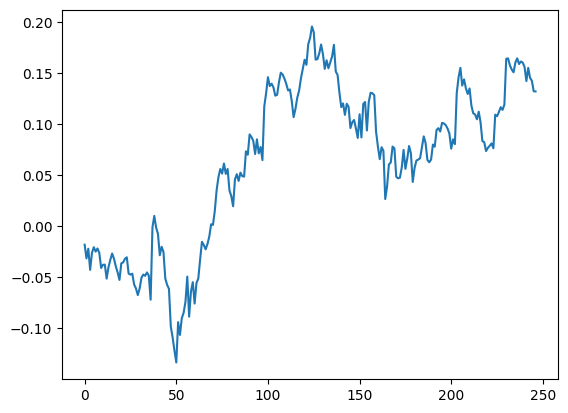

In [5]:
plt.plot(range (0,nsamples-W-2), cr[:-1])

**Task 2:** Which modifications would be required to work with Lasso regression?